In [2]:
library(tidyverse)
library(ggdark)
library("NatParksPalettes")
library("geomtextpath")
source("../scripts//analyze-timeseries.r")

In [55]:
all.runs <- read.csv("../data/2022_07_22_parameter_sweep_stats.csv")
head(all.runs,3)

,X,N_inflow,N_reactors,ave_forward_rate,ave_outflow_rate,graph_type,mass,output_count,output_time,random_seed,...,sim_notes,sim_number,total_time,alpha,alpha.plus,alpha.minus,r2,max.AI,median.AI,weighted.mean.AI
,<int>,<int>,<int>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<dbl>,...,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,1,1,9,5e-07,1,lattice,1000,-1,1,1636141407,...,Lattice Parameter Sweep July 14 2022,10000,100,NA,NA,NA,NA,1,0.5,0.0007873810
2,2,1,9,5e-07,2,lattice,1000,-1,1,3836141407,...,Lattice Parameter Sweep July 14 2022,10001,100,NA,NA,NA,NA,1,0.5,0.0007631074
3,3,1,9,5e-07,5,lattice,1000,-1,1,1037141407,...,Lattice Parameter Sweep July 14 2022,10002,100,NA,NA,NA,NA,1,0.5,0.0006640729


In [112]:
multi.reactor <- all.runs %>% filter(N_reactors == 9, 
                                      ave_forward_rate == 5e-5, 
                                      ave_outflow_rate==10, 
                                      graph_type == "line")
sim_num = multi.reactor$sim_number

In [113]:
ts_data <- read.csv(paste0(sim_number_to_directory(sim_num),"timeseries.csv"))

In [114]:
ts_data <- ts_data %>% filter(value > 1)
ts_data$AI <- assembly_index(ts_data$variable)

In [115]:
coarse_grainned_ts <- ts_data %>% 
                        group_by(reactor, time, AI) %>%
                        summarise(total = sum(value))
normed_ts <- coarse_grainned_ts %>% 
                group_by(reactor, time) %>%
                mutate(normed_total = total/sum(total))

`summarise()` has grouped output by 'reactor', 'time'. You can override using the `.groups` argument.


In [116]:
normed_ts <- normed_ts %>%
                group_by(reactor, time) %>%
                summarise(mean.AI = sum(normed_total*AI),
                          var.AI = sum(sqrt( (normed_total*AI - sum(normed_total*AI))^2 )))

`summarise()` has grouped output by 'reactor'. You can override using the `.groups` argument.


`geom_smooth()` using formula 'y ~ x'



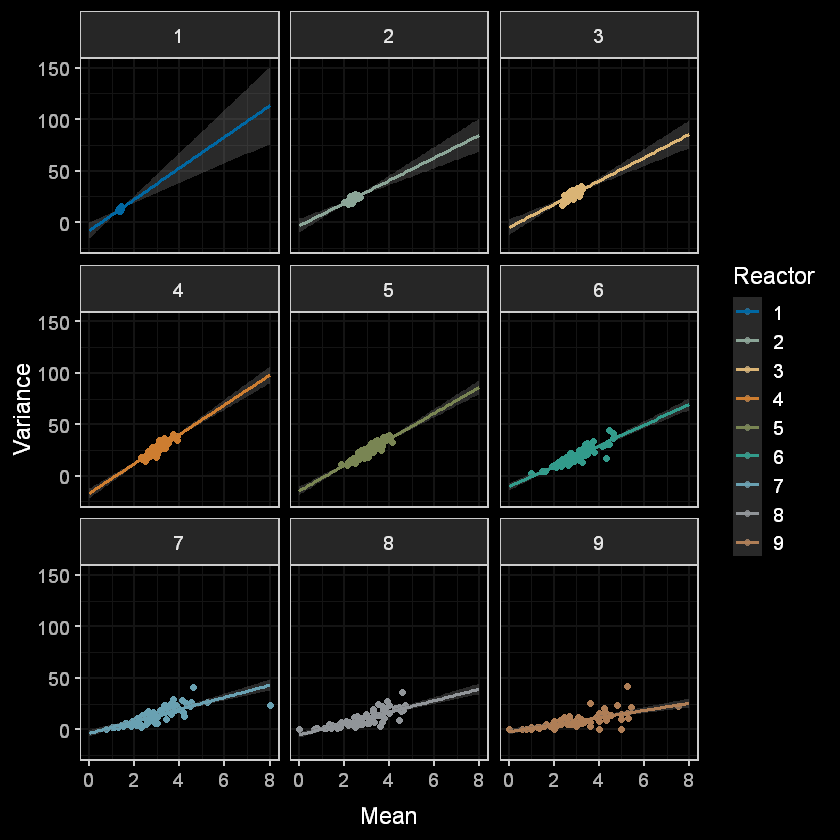

In [117]:
p <- ggplot(normed_ts %>% filter(reactor > 0, time > 25), 
       aes(x = mean.AI, 
           y = var.AI, 
           color = as.factor(reactor))) + 
        geom_point() + 
        facet_wrap(~reactor) + 
        geom_smooth(method = "lm", fullrange=TRUE) +
        dark_theme_bw(base_size = 14) +
        scale_color_manual(values=natparks.pals("Yellowstone", n = 9)) +
        labs(x = "Mean", y = "Variance", color = "Reactor") 
p
# ggsave("../plots/220722-MeanVar-Reactors-Lattice.jpeg", p, height = 243, width = 183, units = "mm")
# ggsave("../plots/220722-MeanVar-Reactors-Lattice.svg", p, height = 243, width = 183, units = "mm")


# Warning! Doing some hacky notebook stuff below. Don't just run these cells and expect it to work.
You need to switch the filter above between execution to actually get both graph types

In [111]:
lattice_norm_ts <- normed_ts
lattice_norm_ts$graph_type = "Lattice"

In [118]:
line_norm_ts <- normed_ts
line_norm_ts$graph_type = "line"

In [119]:
combined_norm_ts <- rbind(lattice_norm_ts, line_norm_ts)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



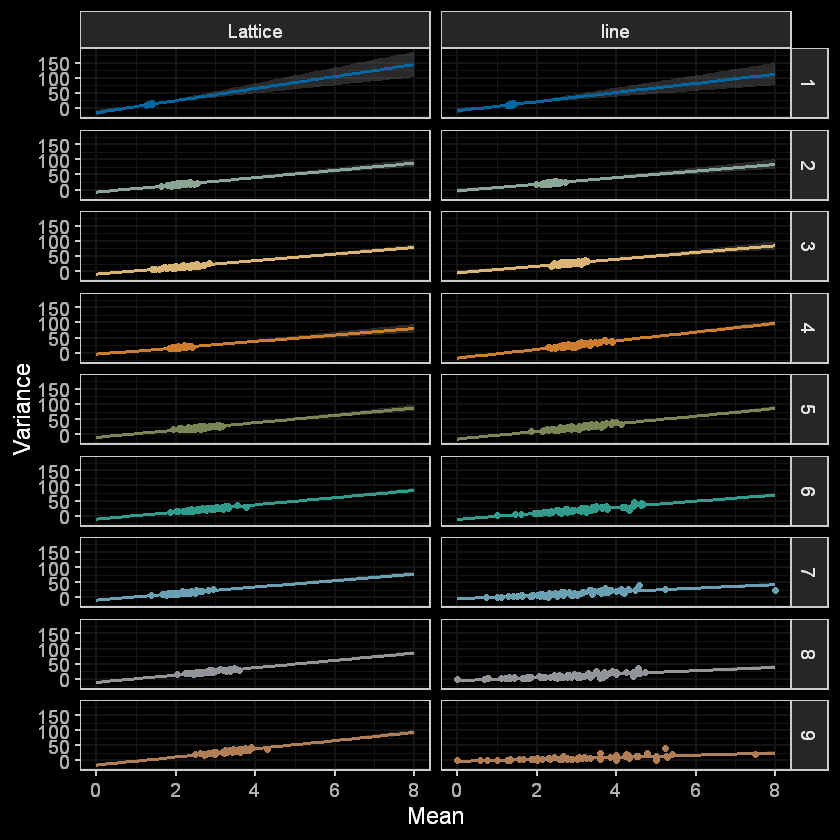

In [130]:
p <- ggplot(combined_norm_ts %>% filter(reactor > 0, time > 25), 
       aes(x = mean.AI, 
           y = var.AI, 
           color = as.factor(reactor))) + 
        geom_point() + 
        facet_grid(vars(reactor), vars(graph_type)) + 
        geom_smooth(method = "lm", fullrange=TRUE) +
        dark_theme_bw(base_size = 14) +
        guides(color = "none") + 
        scale_color_manual(values=natparks.pals("Yellowstone", n = 9)) +
        labs(x = "Mean", y = "Variance", color = "Reactor") 
p
ggsave("../plots/220722-MeanVar-Reactors-Compare.jpeg", p, height = 243, width = 183, units = "mm")
ggsave("../plots/220722-MeanVar-Reactors-Compare.svg", p, height = 243, width = 183, units = "mm")
